Guilherme Andrade, Gabriel Ramos, Daniel Madeira, Rafael Sachetto, Renato Ferreira, Leonardo Rocha, G-DBSCAN: A GPU Accelerated Algorithm for Density-based Clustering, Procedia Computer Science, Volume 18, 2013, Pages 369-378, ISSN 1877-0509, http://dx.doi.org/10.1016/j.procs.2013.05.200.
(http://www.sciencedirect.com/science/article/pii/S1877050913003438)

Abstract: With the advent of Web 2.0, we see a new and differentiated scenario: there is more data than that can be effectively analyzed. Organizing this data has become one of the biggest problems in Computer Science. Many algorithms have been proposed for this purpose, highlighting those related to the Data Mining area, specifically the clustering algorithms. However, these algo- rithms are still a computational challenge because of the volume of data that needs to be processed. We found in the literature some proposals to make these algorithms feasible, and, recently, those related to parallelization on graphics processing units (GPUs) have presented good results. In this work we present the G-DBSCAN, a GPU parallel version of one of the most widely used clustering algorithms, the DBSCAN. Although there are other parallel versions of this algorithm, our technique distinguishes itself by the simplicity with which the data are indexed, using graphs, allowing various parallelization opportu- nities to be explored. In our evaluation we show that the G-DBSCAN using GPU, can be over 100x faster than its sequential version using CPU.
Keywords: Clustering; Dbscan; Parallel computing; GPU


In [1]:
import numpy as np

In [137]:
eps = 0.3
minpts = 10

In [157]:
from sklearn.datasets import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]
d, labels_true = make_blobs(n_samples=250, centers=centers, cluster_std=0.3,
                            random_state=0)

In [158]:
from sklearn.metrics.pairwise import euclidean_distances

core = np.zeros(d.shape[0])

Va = np.zeros( (d.shape[0], 2) )

for i in range(d.shape[0]):
    num_negh = 0
    for j in range(d.shape[0]):
        dist = euclidean_distances(d[i].reshape(1, -1), d[j].reshape(1,-1))[0]
        
        if dist < eps:
            num_negh += 1
    
    Va[i][0] = num_negh
    
    if num_negh >= minpts:
        core[i] = 1

In [159]:
Va[:,0]

array([ 28.,  10.,  25.,   7.,   6.,  18.,  12.,  10.,  29.,  23.,  27.,
        12.,  23.,  33.,  31.,  10.,   8.,  13.,  33.,  31.,  10.,  12.,
         3.,  31.,  14.,   8.,  32.,  33.,  18.,  37.,  25.,  17.,  25.,
        26.,  17.,   9.,  11.,  18.,  12.,  24.,  26.,  14.,  20.,  14.,
         2.,  15.,  23.,  21.,  24.,  28.,  19.,  22.,   9.,   2.,  29.,
        17.,  23.,  20.,   5.,  30.,  24.,  17.,  17.,   6.,  18.,  36.,
        28.,  32.,  18.,  27.,  32.,  31.,  29.,  23.,  31.,   8.,   7.,
         5.,  29.,  32.,  12.,  31.,  30.,  12.,  10.,  11.,  19.,  15.,
        22.,  26.,  10.,   9.,   7.,   9.,  34.,  24.,   2.,   5.,  38.,
         6.,  30.,  24.,  23.,  37.,  21.,  24.,  27.,  33.,  12.,  28.,
        23.,   5.,  21.,  24.,  26.,  25.,  11.,  11.,  17.,  10.,  22.,
        32.,   2.,  27.,   3.,  28.,   9.,  20.,  12.,  19.,   6.,  22.,
        34.,  29.,   9.,   5.,  15.,  31.,  14.,  11.,   3.,  21.,  11.,
        31.,  32.,  26.,   4.,  18.,  27.,  14.,  2

In [160]:
Va[:,1] = np.cumsum(Va[:,0])-Va[:,0]

In [161]:
Ea = np.zeros( int(Va[:,1][-1]) + int(Va[:,0][-1]) )

In [162]:
for i in range(d.shape[0]):
    ni = 0
    for j in range(d.shape[0]):
        dist = euclidean_distances(d[i].reshape(1, -1), d[j].reshape(1,-1))[0]
        if dist < eps:
            #print(i, j, Va[i], int(Va[i][1])+ni)
            Ea[int(Va[i][1])+ni] = j
            ni += 1

In [163]:
Ea

array([   0.,   31.,   33., ...,  232.,  247.,  249.])

In [171]:
def BreadthFirstSearchKernel(j, Fa, Xa):
    tid = j
    if Fa[tid]:
        #print("tid", tid, Fa[tid])
        Fa[tid] = 0
        Xa[tid] = 1
        #print("rng from", int(Va[j][1]), "count", int(Va[j][0]))
        for k in range(int(Va[j][1]), int(Va[j][1])+int(Va[j][0])):
            nid = int(Ea[k])
            if not Xa[nid]:
                #print(k, nid, not Xa[nid])
                Fa[nid] = 1
                
def BreadthFirstSearch(i, cluster, visited, labels):
    Xa = np.zeros(d.shape[0])
    Fa = np.zeros(d.shape[0])
    
    Fa[i] = 1
    
    while np.count_nonzero(Fa) > 0:
        #print("Count nonzero", np.count_nonzero(Fa))
        for j in range(d.shape[0]):
            BreadthFirstSearchKernel(j, Fa, Xa)
        print("Count nonzero", np.count_nonzero(Fa))
        
    for j in range(d.shape[0]):
        if Xa[j]:
            visited[j] = 1
            labels[j] = cluster
            print("Cluster assign", j, cluster)
            
def IdentifyCluster():
    cluster = 0
    labels = np.full( d.shape[0], -1 )
    visited = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if visited[i]:
            continue
        if not core[i]:
            continue
        print("Core ", i)
        
        visited[i] = 1
        labels[i] = cluster
        BreadthFirstSearch(i, cluster, visited, labels)
        cluster += 1
        
    return (cluster, labels)

(cluster, labels) = IdentifyCluster()


Core  0
Count nonzero 21
Count nonzero 3
Count nonzero 0
Cluster assign 0 0
Cluster assign 1 0
Cluster assign 3 0
Cluster assign 5 0
Cluster assign 6 0
Cluster assign 11 0
Cluster assign 15 0
Cluster assign 20 0
Cluster assign 21 0
Cluster assign 24 0
Cluster assign 25 0
Cluster assign 28 0
Cluster assign 31 0
Cluster assign 33 0
Cluster assign 35 0
Cluster assign 37 0
Cluster assign 42 0
Cluster assign 43 0
Cluster assign 45 0
Cluster assign 46 0
Cluster assign 47 0
Cluster assign 52 0
Cluster assign 54 0
Cluster assign 56 0
Cluster assign 58 0
Cluster assign 59 0
Cluster assign 60 0
Cluster assign 61 0
Cluster assign 63 0
Cluster assign 66 0
Cluster assign 72 0
Cluster assign 73 0
Cluster assign 74 0
Cluster assign 75 0
Cluster assign 78 0
Cluster assign 81 0
Cluster assign 84 0
Cluster assign 87 0
Cluster assign 90 0
Cluster assign 93 0
Cluster assign 94 0
Cluster assign 100 0
Cluster assign 101 0
Cluster assign 105 0
Cluster assign 106 0
Cluster assign 111 0
Cluster assign 115 0
Cl

C:\Users\mshoc\Anaconda3\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(250, -1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [166]:
import pandas as pd

df = pd.DataFrame.from_records( list( 
        map( lambda i: ( d[i][0], d[i][1], labels[i]),  range(d.shape[0])) ), columns=['x', 'y', 'class'] )

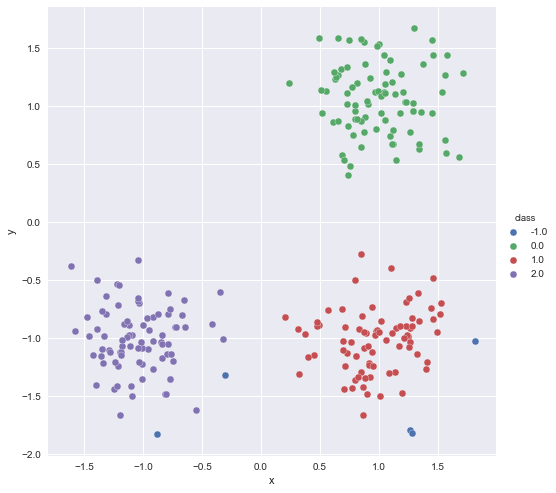

In [167]:
%matplotlib inline
import seaborn as sns

sns.pairplot(df, x_vars=['x'], y_vars=['y'], hue="class", size=7)